# Data cleaning projects

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyarrow as pa

## Clean listing data

### Setting requirements

In [2]:
listing = pd.read_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Airbnb\Sydney\2024\data load\listing_2024.parquet')

In [3]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11340 entries, 1 to 15547
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              11340 non-null  int64         
 1   name                            11340 non-null  object        
 2   host_id                         11340 non-null  int64         
 3   host_name                       11340 non-null  object        
 4   host_since                      11340 non-null  datetime64[ns]
 5   host_response_time              10273 non-null  object        
 6   host_is_superhost               11311 non-null  object        
 7   host_listings_count             11340 non-null  int64         
 8   host_has_profile_pic            11340 non-null  object        
 9   host_identity_verified          11340 non-null  object        
 10  neighbourhood_cleansed          11340 non-null  object        
 11  latitud

In [117]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

- [x] get rid of unnecessary columns
  
A- Price factors:
  - [x] facitlity: property_type, room_type, accomodates, bathrooms, bathrooms text, bedrooms, beds, amenities, price
  - [x] location: latitde, longitude, neighbourhood_cleanse,
  - [x] time: calendar factors
  

B- Occupancy rate:
  - [x] location, time, price factors
  - [x] occupancy metrics: availability, minimum nights, has_availability
  - [x] host factors: check host_location, convert host_since/ response time/ response rate/ acceptance rate/ superhost to suitable data types
  - [x] review related: keep all review column in listing, and count the number of review for each listing in review data

C- Other:
  - [x] Outliers check
  - [x] Handle null values

In [3]:
col_to_drop = ['neighbourhood_group_cleansed', 'listing_url', 'scrape_id', 
                'last_scraped','source', 'description','neighborhood_overview', 'picture_url',
                'host_url','host_thumbnail_url','host_picture_url', 'host_neighbourhood', 
                'host_total_listings_count', 'neighbourhood', 
                'minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 
                'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm', 
                'calendar_updated', 'calendar_last_scraped','first_review',
                'last_review',
                'calculated_host_listings_count_entire_homes',
                'calculated_host_listings_count_private_rooms', 
                'calculated_host_listings_count_shared_rooms']

In [4]:
df_listing = listing.drop(col_to_drop, axis = 1)

In [5]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15548 entries, 0 to 15547
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15548 non-null  int64  
 1   name                            15548 non-null  object 
 2   host_id                         15548 non-null  int64  
 3   host_name                       15548 non-null  object 
 4   host_since                      15548 non-null  object 
 5   host_location                   11397 non-null  object 
 6   host_about                      9108 non-null   object 
 7   host_response_time              12790 non-null  object 
 8   host_response_rate              12790 non-null  object 
 9   host_acceptance_rate            13532 non-null  object 
 10  host_is_superhost               15504 non-null  object 
 11  host_listings_count             15548 non-null  int64  
 12  host_verifications              

### A - Clean data related to price factors

In [6]:
#checking format of property_type, room_type, accommodates
df_listing.groupby('room_type').count()['id']

room_type
Entire home/apt    12345
Hotel room            77
Private room        3036
Shared room           90
Name: id, dtype: int64

In [7]:
#checking format of property_type, room_type, accommodates
df_listing.groupby('property_type').count()['id'].reset_index().sort_values(by = 'id', ascending=False)

,property_type,id
17,Entire rental unit,6824
13,Entire home,3467
39,Private room in home,1493
43,Private room in rental unit,900
12,Entire guesthouse,410
...,...,...
36,Private room in earthen home,1
42,Private room in minsu,1
49,Private room in vacation home,1
48,Private room in treehouse,1


In [8]:
#checking format of property_type, room_type, accommodates
df_listing.groupby('accommodates').count()['id']

accommodates
1      914
2     5403
3      973
4     3403
5      981
6     1713
7      372
8      926
9      154
10     407
11      59
12     143
13      12
14      25
15      13
16      50
Name: id, dtype: int64

In [9]:
# bathrooms na values
df_listing['bathrooms'].isna().sum()

946

In [10]:
# compared null value with bathroom_text
df_listing[df_listing['bathrooms'].isna()][['bathrooms','bathrooms_text']].head(5)

,bathrooms,bathrooms_text
11,NaN,1 bath
47,NaN,1 bath
63,NaN,1 bath
67,NaN,1.5 baths
92,NaN,None


In [11]:
# checking if the bathrooms text can fill the na in bathrooms
len(df_listing[(df_listing['bathrooms'].isna()) & (df_listing['bathrooms_text'].notna())])

943

In [12]:
# testing samples
sample = pd.DataFrame(['1.5','1.0', '1 bath','1.5 shared bath'], columns=['bathrooms'])
sample['bath'] = sample['bathrooms'].str.split(' ',expand=True)[0]
sample

,bathrooms,bath
0,1.5,1.5
1,1.0,1.0
2,1 bath,1
3,1.5 shared bath,1.5


In [13]:
#convert value on bathrooms text to number
df_listing['bathrooms_text'] = df_listing['bathrooms_text'].str.split(' ',expand=True)[0]

In [14]:
# fillna in bathrooms with bathrooms text value
df_listing['bathrooms'] = df_listing['bathrooms'].fillna(df_listing['bathrooms_text'])

In [15]:
# clean and transform to numeric type for bathrooms column
df_listing['bathrooms'] = pd.to_numeric(df_listing['bathrooms'], errors='coerce')

In [16]:
# check the how many na value left
f'There are {df_listing['bathrooms'].isna().sum()} listings that has null bath room values accounting for {df_listing['bathrooms'].isna().sum()*100/len(df_listing)}% of total data'

'There are 4 listings that has null bath room values accounting for 0.025726781579624387% of total data'

In [17]:
# checking amenities
df_listing['amenities'].sample(10)

2474     ["Essentials", "Heating", "TV", "Smoke alarm",...
778      ["Outdoor furniture", "Room-darkening shades",...
15539    ["Fire extinguisher", "Bed linens", "Washer", ...
11492    ["Outdoor furniture", "Room-darkening shades",...
2493     ["Fire extinguisher", "Outdoor furniture", "Be...
187      ["TV", "Smoke alarm", "Wifi", "Free parking on...
9972     ["Fire extinguisher", "Room-darkening shades",...
2410     ["Outdoor furniture", "Indoor fireplace", "Bea...
4102     ["Bed linens", "Washer", "Shower gel", "Shampo...
10361    ["Fire extinguisher", "Outdoor furniture", "Be...
Name: amenities, dtype: object

In [18]:
df_listing['amenities_copied'] = df_listing['amenities']

In [19]:
# clean format
df_listing['amenities'] = df_listing['amenities'].apply(lambda x: x.replace('[','').replace(']','').replace('"','').replace(' ,',',').replace(', ',',').split(','))

In [20]:
# adding the number of amenities
df_listing['amenities_count'] = df_listing['amenities'].apply(len)

In [21]:
# clean price column. The currency is local currency (AUD)
df_listing['price'].head(10)

0      $185.00
1      $100.00
2      $347.00
3      $100.00
4      $736.00
5      $359.00
6    $1,600.00
7       $70.00
8      $194.00
9      $178.00
Name: price, dtype: object

In [22]:
df_listing['price_AUD'] = df_listing['price'].str.replace('$','')
df_listing['price_AUD'] = df_listing['price_AUD'].str.replace(',','')
df_listing['price_AUD'] = df_listing['price_AUD'].str.replace('.00','')
df_listing['price_AUD'] = pd.to_numeric(df_listing['price_AUD'])

### B - Clean location/host/review factors

In [ ]:
# checking neighborhood format. The format seem to be good, no need further edit
df_listing.groupby('neighbourhood_cleansed').count()['id']

In [ ]:
# host factors: host_since convert to datetime, check lost_location, convert response time/ response rate/ acceptance rate/ superhost to suitable data types
df_listing.groupby('host_location').count()['id']

In [25]:
# convert the host since into date time
df_listing['host_since'] = pd.to_datetime(df_listing['host_since'], errors='coerce')

In [26]:
# checking host_response time
df_listing.groupby('host_response_time').count()['id']

host_response_time
a few days or more     325
within a day           907
within a few hours    1757
within an hour        9801
Name: id, dtype: int64

In [27]:
# checking response rate: remove % sign and convert to numeric
df_listing['host_response_percent'] = pd.to_numeric(df_listing['host_response_rate'].str.replace('%',''))

In [28]:
# checking host acceptance rate
df_listing['host_acceptance_percent'] = pd.to_numeric(df_listing['host_acceptance_rate'].str.replace('%',''))

In [ ]:
#convert boolean type 
df_listing['host_is_superhost'].astype('bool')
df_listing['host_identity_verified'].astype('bool')
df_listing['host_has_profile_pic'].astype('bool')
df_listing['instant_bookable'].astype('bool')
df_listing['host_has_profile_pic'].astype('bool')

In [ ]:
# recheck columns and drop unncessary columns
df_listing.info()

In [30]:
col_to_drop2 = ['host_location', 'host_about', 'host_acceptance_rate', 'bathrooms_text', 'price','host_response_rate','host_verifications']

In [31]:
df_listing = df_listing.drop(col_to_drop2, axis =1)

In [ ]:
df_listing.info()

### C - Handle missing values/ outliers

#### Handle missing values of accommodates, rooms, beds

In [ ]:
# outliers detection: accommodates
df_listing.groupby('accommodates').count()['id'] # there seem no outliers in range of accomodates

In [ ]:
# checking outliers for bedrooms
df_listing.groupby('bedrooms').count()['id'].sort_values(ascending=False)

In [35]:
# check what kind of listing has 0 bedrooms.
df_listing[df_listing['bedrooms'] == 0][['beds','bedrooms','property_type']].sample(10)

,beds,bedrooms,property_type
14801,2.0,0.0,Entire rental unit
10198,2.0,0.0,Room in hotel
900,1.0,0.0,Entire guesthouse
13882,2.0,0.0,Entire rental unit
6456,1.0,0.0,Entire rental unit
5415,1.0,0.0,Room in hotel
3830,1.0,0.0,Entire rental unit
10232,0.0,0.0,Entire rental unit
5550,1.0,0.0,Entire guesthouse
4953,1.0,0.0,Entire rental unit


In [36]:
# question: should the 0 bedrooms value be fill with the beds value assuming 1 bed = 1 bedroom. If so, what is the average bed per bedroom
bed_num = df_listing[(df_listing['beds'] != 0) & (df_listing['bedrooms'] != 0)]['beds'].sum()
bedroom_num = df_listing[(df_listing['beds'] != 0) & (df_listing['bedrooms'] != 0)]['bedrooms'].sum()
bed_num/bedroom_num 

1.1539369613977097

In [37]:
# since the average beds per bedroom is nearly 01, the 0 number of bedrooms col can get replace with non-zero in beds col and fill na in bedrooms with beds
df_listing['bedrooms'] = df_listing.apply(lambda x: x['beds'] if x['bedrooms'] == 0 else x['bedrooms'], axis = 1 )

In [38]:
# fill na values of bedrooms with the value of beds available
df_listing['bedrooms'] = df_listing['bedrooms'].fillna(df_listing['beds'])

In [39]:
# for the rest of null and 0 bedrooms value, the accommodates will be used as proxy: shared rooms will have accomodates = bedrooms, other roomtype: bedrooms = accommodates/2 rounded
df_listing['bedrooms'] = np.where(((df_listing['bedrooms'].isna()) | (df_listing['bedrooms'] == 0)) & (df_listing['room_type'] == 'Shared room'), 
                                  df_listing['accommodates'], df_listing['bedrooms'])

In [40]:
df_listing['bedrooms'] = np.where(((df_listing['bedrooms'].isna()) | (df_listing['bedrooms'] == 0)), round(df_listing['accommodates']/2,0), df_listing['bedrooms'])

In [41]:
# the 0.5 bedromms will be rounded down to 0, hence, it is necessary to replace 1 for those value
df_listing['bedrooms'] = np.where(df_listing['bedrooms'] == 0, df_listing['accommodates'], df_listing['bedrooms'])

In [42]:
# fill na in has_availability column for rows have availability_365 different from 0
df_listing['has_availability'] = np.where(df_listing['has_availability'].isna(), 
                                          np.where(df_listing['availability_365'] !=0, True, False), df_listing['has_availability'])

In [43]:
df_listing['has_availability'] = df_listing['has_availability'].replace({'t': True, 'f': False})

C:\Users\tamla_f1yewqh\AppData\Local\Temp\ipykernel_8052\2675808758.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_listing['has_availability'] = df_listing['has_availability'].replace({'t': True, 'f': False})


In [ ]:
df_listing['has_availability'].astype('bool')

#### Handle outliers for price and minimum nights

In [45]:
# checking null price
df_listing['price_AUD'].isna().sum()

949

In [46]:
# checking samples the null-price listing if there is any bookings, reviews, ... If there is like no activity, maybe these listings are no longer in business
df_listing[df_listing['price_AUD'].isna()][['availability_30','availability_60','availability_90','availability_365','host_acceptance_percent','has_availability']].sample(10)

,availability_30,availability_60,availability_90,availability_365,host_acceptance_percent,has_availability
11545,7,16,32,234,56.0,True
9217,0,0,0,14,67.0,True
9641,0,0,0,0,100.0,True
4685,30,60,90,365,NaN,True
7781,0,0,0,0,99.0,True
2889,0,0,0,0,71.0,True
2813,0,0,0,0,100.0,True
11088,0,0,0,0,96.0,True
11919,0,0,0,0,90.0,True
10202,0,0,0,0,NaN,True


In [47]:
# checking how many of null-price listings has 0 in availability, 0 reviews and null in acceptance rate
row_to_drop = df_listing[(df_listing['price_AUD'].isna()) & (df_listing['has_availability'] == False)].index
len(row_to_drop)

14

In [48]:
# drop these rows as these listing does not seem to be in operation
df_listing = df_listing.drop(index = row_to_drop)

In [49]:
df_listing[['price_AUD','minimum_nights']].describe()

,price_AUD,minimum_nights
count,14599.000000,15534.000000
mean,346.667100,16.599459
std,545.697468,34.640492
min,16.000000,1.000000
25%,140.000000,2.000000
50%,206.000000,2.000000
75%,341.500000,6.000000
max,13500.000000,500.000000


array([[<Axes: title={'center': 'price_AUD'}>,
        <Axes: title={'center': 'minimum_nights'}>]], dtype=object)

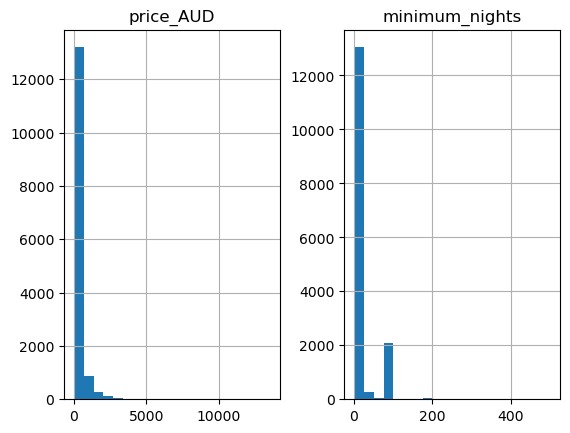

In [50]:
df_listing[['price_AUD','minimum_nights']].hist(bins = 20)

- The **price** column has max value of 1 million AUD while the 75% percentile (Q3) is just 2196 AUD. Hence there are ouliers for price
- The **minimum nights** has max value of 1115 nights while the 75% percentile is 7, hence minimum nights also contain outliers

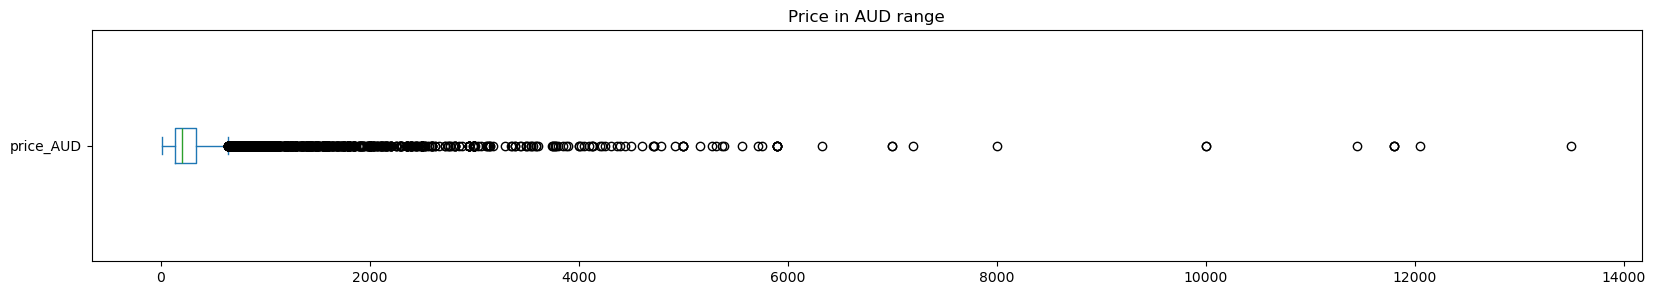

The upper limit for price is 643.75
The lower limit for price is -162.25
There are 1506 rows have price higher than upper limit accounting for 9.69% of total


In [51]:
# the box plot for price column as follow
fig, ax = plt.subplots(figsize=(20,3))
df_listing['price_AUD'].plot(kind = 'box', vert = False)
ax.set_title('Price in AUD range')
plt.show()

# identify the outliers with 1.5*IQR rules - price column:
price_Q1 = df_listing['price_AUD'].quantile(0.25)
price_Q3 = df_listing['price_AUD'].quantile(0.75)
price_IQR = price_Q3 - price_Q1
price_upper_bound = price_Q3 + 1.5*price_IQR
price_lower_bound = price_Q1 - 1.5*price_IQR
upper_num = len(df_listing[df_listing['price_AUD'] > price_upper_bound])

print(f'The upper limit for price is {price_upper_bound}')
print(f'The lower limit for price is {price_lower_bound}')
print(f'There are {upper_num} rows have price higher than upper limit accounting for {round(upper_num*100/len(df_listing),2)}% of total')

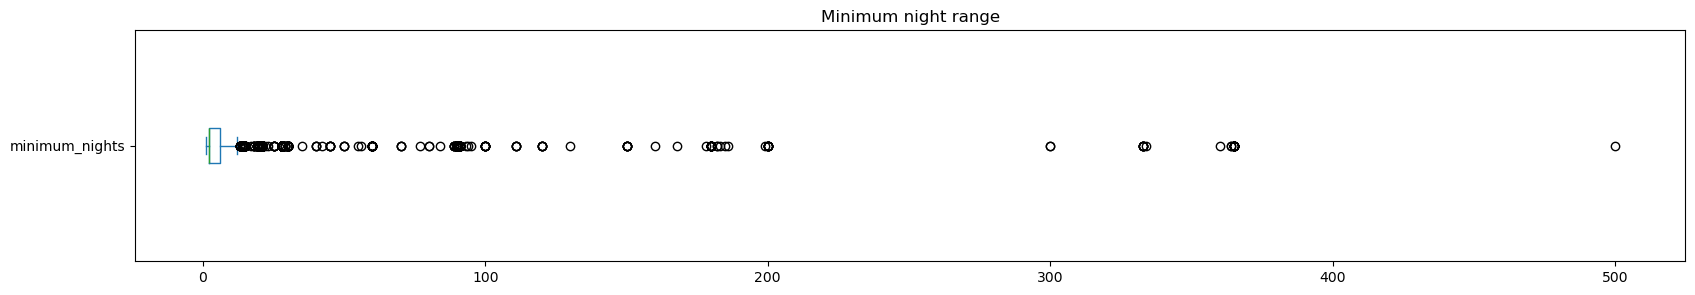

The upper limit for minimum nights is 12.0
The lower limit for minimum nights is -4.0
There are 2895 rows have number of minimum nights higher than upper limit accounting for 18.64% of total


In [52]:
# the box plot for minimum_nights columns 
fig, ax = plt.subplots(figsize = (20,3))
df_listing['minimum_nights'].plot(kind = 'box', vert = False)
ax.set_title('Minimum night range')
plt.show()

# calculate 1.5IQR range for outliers in minimum nights:
minNights_Q1 = df_listing['minimum_nights'].quantile(0.25)
minNights_Q3 = df_listing['minimum_nights'].quantile(0.75)
minNights_IQR = minNights_Q3 - minNights_Q1
minNights_upper_bound = minNights_Q3 + 1.5*minNights_IQR
minNights_lower_bound = minNights_Q1 - 1.5*minNights_IQR
minNights_upper = len(df_listing[df_listing['minimum_nights'] > minNights_upper_bound])

print(f'The upper limit for minimum nights is {minNights_upper_bound}')
print(f'The lower limit for minimum nights is {minNights_lower_bound}')
print(f'There are {minNights_upper} rows have number of minimum nights higher than upper limit accounting for {round(minNights_upper*100/len(df_listing),2)}% of total')

- There are about 8% of rows have outliers value in price, which is fair amount that will be dropped
- However, considering the fact that about a fifth of data has the minimum nights over upper limit, it is quite a lot of data to get rid of.
- Conidering the short term rental stay regulation in Sydney, the minimum night upper bound will be reset to 31 days

In [53]:
# dropping rows with higher than upper limit for price and minimum nights:
df_listing = df_listing.drop(df_listing[df_listing['price_AUD']> price_upper_bound].index, axis = 0)
df_listing = df_listing.drop(df_listing[df_listing['minimum_nights']> 31].index, axis = 0)

In [54]:
# recheck data after cleaning
df_listing[['price_AUD','minimum_nights']].describe()

,price_AUD,minimum_nights
count,11340.000000,12054.000000
mean,225.952910,3.539074
std,124.824082,4.886916
min,16.000000,1.000000
25%,140.000000,1.000000
50%,197.000000,2.000000
75%,286.000000,3.000000
max,643.000000,30.000000


In [55]:
# recheck price range
df_listing['price_AUD'].isna().sum()

714

In [56]:
print(f'There are {df_listing['price_AUD'].isna().sum()} listings that does not price listed accounting for {round(df_listing['price_AUD'].isna().sum()*100/len(df_listing),2)}% of total')

There are 714 listings that does not price listed accounting for 5.92% of total


In [57]:
# drop null price row
df_listing = df_listing.drop(df_listing[df_listing['price_AUD'].isna()].index, axis = 0)

In [ ]:
# check listing data
df_listing.info()

#### Draft check data after cleaning

The average booking rate of 50% (estimated by AirDNA) for Airbnb in Bangkok. Hence, there will couple of testing to see if the data after cleaning is fit enough for analysis

In [62]:
# draft check the occupancy rate for listing over l12ms: Occupancy rate = (minimum_nights * number_of_review_l12ms)/ availability_365

# first copied data
df_copied = df_listing.copy()

In [ ]:
df_copied.info()

In [64]:
# draft check number of nights booked. nights booked based on minimum and number of reviews
nights_booked = df_copied['number_of_reviews_ltm']*df_copied['minimum_nights']
print(f'On average, the number of night booked is {nights_booked.mean()} nights per listings in L12ms')

On average, the number of night booked is 33.64832451499118 nights per listings in L12ms


The number seems to be quite small considering that the whole Airbnb just got under 30 days of booking all year round. Howerver, it is neccessary to take into account these factors:
- availability of each listing is different, not all host lease their property for full year
- the number of reviews is just a proxy to estimate for over the last 12 months as some guests may not leave their review, estimated there are about 70% guests leaving reviews

In [65]:
len(df_copied[df_copied['number_of_reviews_ltm'] == 0])

1774

For the listing has 0 reviews but still has availability, the number of night books over the L12ms will be evaluated using the availability in 90 days taken into consideration of 4 groups of availability:
- 0-90 days
- 90-180 days
- 180-270 days
- 270-365 days

In [66]:
# grouping availability
df_copied['availability'] = np.where(df_copied['availability_365'] <= 90, 90, 
                                     np.where((df_copied['availability_365'] <= 180) & (df_copied['availability_365'] > 90), 180,
                                              np.where((180 < df_copied['availability_365']) & (df_copied['availability_365']  <= 270 ),270, 365)))

In [67]:
df_copied['booking'] = np.where(df_copied['availability'] == 90, (90-df_copied['availability_90']),
                                np.where(df_copied['availability'] == 180, (90-df_copied['availability_90'])*2,
                                         np.where(df_copied['availability'] == 270, (90-df_copied['availability_90'])*3,(90-df_copied['availability_90'])*4)))

In [68]:
df_copied['stay'] = np.where(df_copied['minimum_nights'] <=3, 3, df_copied['minimum_nights'])

In [69]:
df_copied['night_booked'] = np.where(df_copied['number_of_reviews_ltm']!= 0, (df_copied['number_of_reviews_ltm']/0.7) * df_copied['stay'],
                                      np.where(df_copied['has_availability'] == True, df_copied['booking'], 0))

In [70]:
len(df_copied[(df_copied['night_booked'] == 0) & (df_copied['has_availability'] == True)])

151

In [71]:
df_copied['night_booked'].mean(skipna= True)

78.06657848324515

In [72]:
df_copied['occupancy rate'] = df_copied['night_booked']/df_copied['availability']

In [73]:
# there may be some infinity value as some listing have 0 availability
len(df_copied[df_copied['availability_365'] == 0])

93

In [74]:
occ_rate = df_copied['occupancy rate'].replace(np.Inf, np.nan).mean(skipna=True)
f'The occupancy rate is estimated around {occ_rate*100:.2f} %'

'The occupancy rate is estimated around 49.30 %'

Compare with data published on InsideAirbnb which state that the average booking is about 72 days per year. Our dataset resulted in ~70 days which is very close to the estimation.

In [75]:
# recheck data 
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11340 entries, 1 to 15547
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              11340 non-null  int64         
 1   name                            11340 non-null  object        
 2   host_id                         11340 non-null  int64         
 3   host_name                       11340 non-null  object        
 4   host_since                      11340 non-null  datetime64[ns]
 5   host_is_superhost               11311 non-null  object        
 6   host_listings_count             11340 non-null  int64         
 7   host_has_profile_pic            11340 non-null  object        
 8   host_identity_verified          11340 non-null  object        
 9   neighbourhood_cleansed          11340 non-null  object        
 10  latitude                        11340 non-null  float64       
 11  longitu

### Save clean file

In [59]:
df_listing.to_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Airbnb\Sydney\2024\data cleaned\listing_2024_clean.parquet')

## Clean calendar and reviews data

### Loading and checking format

In [203]:
review = pd.read_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Airbnb\Sydney\2024\reviews_2024.parquet')

In [204]:
calendar = pd.read_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Airbnb\Sydney\2024\calendar_2024.parquet')

In [176]:
review.head()

,column0,listing_id,id,date,reviewer_id,reviewer_name,comments
0,0,27934,1094339,2012-04-07,1368195,Michael,We stayed in the apartment for a week and we e...
1,1,27934,1241042,2012-05-07,2007324,Scott,My girlfriend and I recently stayed in Nuttee'...
2,2,27934,1523384,2012-06-20,2263352,Marc,I stayed for one month at the condo and was re...
3,3,27934,1655571,2012-07-08,558987,Leyla,Nuttee was a great host! I really enjoyed her ...
4,4,27934,1972192,2012-08-13,2359865,Rachel,Nuttee was an amazing host. She and her daught...


In [177]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438958 entries, 0 to 438957
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   column0        438958 non-null  int64 
 1   listing_id     438958 non-null  int64 
 2   id             438958 non-null  int64 
 3   date           438958 non-null  object
 4   reviewer_id    438958 non-null  int64 
 5   reviewer_name  438953 non-null  object
 6   comments       438901 non-null  object
dtypes: int64(4), object(3)
memory usage: 23.4+ MB


In [178]:
calendar.head()

,column0,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,0,55681,2024-06-27,False,"$1,105.00",None,2.0,365.0
1,1,55681,2024-06-28,False,"$1,105.00",None,2.0,365.0
2,2,55681,2024-06-29,False,"$1,105.00",None,2.0,365.0
3,3,55681,2024-06-30,False,"$1,105.00",None,2.0,365.0
4,4,55681,2024-07-01,False,"$1,105.00",None,2.0,365.0


In [179]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8632539 entries, 0 to 8632538
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   column0         int64  
 1   listing_id      int64  
 2   date            object 
 3   available       bool   
 4   price           object 
 5   adjusted_price  object 
 6   minimum_nights  float64
 7   maximum_nights  float64
dtypes: bool(1), float64(2), int64(2), object(3)
memory usage: 469.3+ MB


In [205]:
df_review = review.copy()

In [206]:
df_calendar = calendar.copy()

### Setting requirements

A - For review table:
- [x] drop column0
- [x] convert date into datetime format

B - For calendar table:
- [x] drop column0
- [x] convert price into price_baht
- [x] convert date into datetime format
- [x] clean adjusted-price

C - Other:
- [ ] Remove those lines that the listings id are not in listings table (as some listing has been removed at the last step of cleaning listings)

### Cleaning process

In [207]:
# drop column0 in both table
# remove reviewer names and comments column on review
df_review = df_review.drop(columns=['reviewer_name','comments'])

In [208]:
# convert datetime format in both table
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_review['date'] = pd.to_datetime(df_review['date'])

In [209]:
# conver the price in calendar to local currency
df_calendar['price_AUD'] = df_calendar['price'].apply(lambda x: x.replace('$','').replace(',','').replace('.00',''))

In [210]:
df_calendar['price_AUD'] = pd.to_numeric(df_calendar['price_AUD'])

In [211]:
df_calendar = df_calendar.drop('price',axis = 1)

In [212]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5675024 entries, 0 to 5675023
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   adjusted_price  object        
 4   minimum_nights  float64       
 5   maximum_nights  float64       
 6   price_AUD       float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 303.1+ MB


In [213]:
# check adjusted price in calendar. The adjusted price has mostly null value which is not quite useful, hence it will be droped
df_calendar['adjusted_price'].isna().sum()

5668454

In [214]:
df_calendar = df_calendar.drop('adjusted_price', axis= 1)

In [215]:
# clean out listing id that has been removed in listing data by created a column to check whether the listing exits and delete the False value later on
df_calendar['listing_to_remove'] = df_calendar['listing_id'].isin(df_listing['id'])

In [216]:
# clean out listing id that has been removed in listing data by created a column to check whether the listing exits and delete the False value later on

df_review['listing_to_remove'] = df_review['listing_id'].isin(df_listing['id'])

In [217]:
# delete false value
df_review = df_review[df_review['listing_to_remove']]

In [218]:
# delete false value
df_calendar = df_calendar[df_calendar['listing_to_remove']]

In [219]:
# drop the listing_to_remove in both table
df_calendar = df_calendar.drop(columns=['listing_to_remove'])
df_review = df_review.drop(columns=['listing_to_remove'])

In [220]:
# check unique value of listing in both table
len(df_review['listing_id'].unique())

9920

In [221]:
# the number of listings on calendar now match the number of listings on listing table
len(df_calendar['listing_id'].unique())

11340

### Save clean files

In [223]:
df_review.to_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Airbnb\Sydney\2024\reviews_2024_cleaned.parquet', index = False)

In [224]:
df_calendar.to_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Airbnb\Sydney\2024\calendar_2024_cleaned.parquet', index = False)